# Introduction to Machine Learning using Muon Tracks in CMS - worked example  
This is a worked example of the Coding Camp 2 activity. Analysis is based on [Natasha Holmes' weighted chi-sq](https://docs.google.com/document/d/1VP2fAFiVm1FqjqD4D-jRctjdIrMiSmBWAYw_cqBhxV0/edit?usp=sharing) and Chapter 4 of 'Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow' by O'Reilly.

## Problem  
Can we use machine learning to improve our fitting techniques?  

## Plan  
Use machine learning regression techniques to fit model functions to CMS tracker data for a muon. This is based on the Muon Tracks activity with machine learning application.

## Data  
For muon track 1, pt = 25 GeV, particle is a muon with q= -1. muon_track_1.csv has 3 rows of header info to ignore for analysis as a pandas dataframe. Data include x,y coordinates of the muon's trajectory but not z. The tracker has a spatial resolution on the order of 0.5 cm due to physical size of the hardware elements.  

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.optimize import curve_fit

In [64]:
track = pd.read_csv('../data/muon_track_1.csv', skiprows=2)
track.head()

,x,y
0,0.038726,-0.015958
1,0.131212,-0.055478
2,0.223866,-0.094564
3,0.316684,-0.133215
4,0.409664,-0.171429


## Analysis  


## Linear Regression

We will use the function LinearRegression from the Scikit-Learn library to train a linear regression model. Training a model means setting its parameters so that the model best fits the training dataset using a performace measure. This is done by finding parameters in the model that minimizes the Root Mean Square Error or the Mean Square Error by minimizing the (cost) function. 

The LinearRegression class is based on [scipy.linalg.lstsq()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) function which calculates the least squares solution to an equation. You can see more details on the function and the format of the LinearRegression class [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)The array must be 2D so we will reshape the data before fitting.


In [65]:
# fit a linear model to a set of muon tracks in CMS using linear regression
from sklearn.linear_model import LinearRegression

X = track['x'].values.reshape(-1, 1)
Y = track['y'].values.reshape(-1, 1)

lin_reg = LinearRegression()
lin_reg.fit(X,Y)

#Print the model's coefficient and intercept
regg_params = lin_reg.coef_, lin_reg.intercept_
regg_params

(array([[-0.3862925]]), array([-0.01158637]))

In [66]:
#Print the model's predictions for a new array X_new
X_new = np.array([[0],[2]])
lin_reg.predict(X_new)

array([[-0.01158637],
       [-0.78417137]])

## Linear Model Fitting using Stochastic Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide variety of problems by iteratively changing parameters to minimize a cost function. Gradient Descent measures the local gradient of the error function and goes in the direction of descending gradient. The size of the step is the learning rate. 

We will use SGDRegressor from the sklearn library to implement machine learning techniques to fit the linear model. SGD stands for Stochastic Gradient Descent: picks a random instance in the training set at every step and computes the gradients based only on that single instance. More details about the function can be found [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

We will perform Linear Regression using SGD for maximum 1000 epochs (max_iter=1000) or until the loss drops by less than 1e-3 during one epoch (tol=1e-3), starting with a learning rate of 0.3 (eta0=0.3).

In [55]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=1.1, random_state=42)
sgd_reg.fit(X,Y.ravel())
sgd_params = sgd_reg.coef_, sgd_reg.intercept_
sgd_params

(array([-0.38488234]), array([-0.01331508]))

The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too quickly, you may get stuck in a local minimum or even end up frozen before reaching the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time.

In [67]:
#Decrease the learning rate to 0.1
sgd1_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.1, random_state=42)
sgd1_reg.fit(X,Y.ravel())
sgd1_params = sgd1_reg.coef_, sgd1_reg.intercept_
sgd1_params

(array([-0.2947676]), array([-0.12138168]))

In [68]:
#Increase the learning rate to 3
sgd2_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=3, random_state=42)
sgd2_reg.fit(X,Y.ravel())
sgd2_params = sgd2_reg.coef_, sgd2_reg.intercept_
sgd2_params

(array([7307743.39006013]), array([-25203458.77137183]))

## Polynomial Regression
We know that the path of a muon is not a simple straight line. We can use a linear model to fit nonlinear data by adding features to our variable X in order to use linear regression. We can now fit our data to a parabola by adding a second feature.

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_reg = LinearRegression()
poly_reg.fit(X_poly, Y)
poly_regg_params = poly_reg.coef_, poly_reg.intercept_
poly_regg_params

(array([[-0.41220111,  0.01327689]]), array([-0.00323752]))

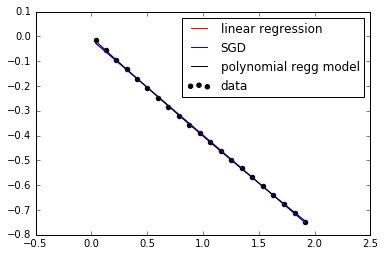

,x,y,linear regg model yvals,polynomial regg model yvals,linear regg model residuals,polynomial regg model residuals
0,0.038726,-0.015958,-0.026546,-0.019181,0.010588,0.003223
1,0.131212,-0.055478,-0.062273,-0.057095,0.006795,0.001617
2,0.223866,-0.094564,-0.098064,-0.094850,0.003500,0.000286
3,0.316684,-0.133215,-0.133919,-0.132443,0.000704,-0.000772
4,0.409664,-0.171429,-0.169837,-0.169873,-0.001592,-0.001556


In [59]:
# compare the models using chi-sq

# plotting the original data and the optimized model (i.e., trendline)
plt.scatter(track['x'], track['y'], label="data", color='k')
plt.plot(track['x'], linear_model(track['x'], regg_params[0][0][0],regg_params[1][0]), label="linear regression",color='red')
plt.plot(track['x'], linear_model(track['x'], sgd_params[0],sgd_params[1]), label="SGD",color='blue')
plt.plot(track['x'], (poly_regg_params[0][0][1]*np.square(track['x']) + poly_regg_params[0][0][0]*track['x'] + poly_regg_params[1]), label="polynomial regg model",color='black')


plt.legend()
plt.show()

track['linear regg model yvals'] = linear_model(track['x'], regg_params[0][0][0],regg_params[1][0])
track['polynomial regg model yvals'] = poly_regg_params[0][0][1]*np.square(track['x']) + poly_regg_params[0][0][0]*track['x'] + poly_regg_params[1][0]

track['linear regg model residuals'] = track['y'] - track['linear regg model yvals']
track['polynomial regg model residuals'] = track['y'] - track['polynomial regg model yvals']


track.head()

## Regularized Models

So far we have trained models setting its parameters so that the model best fits the training set. If you perform a high-degree polynomial regression, you will fit the training data much better than the Linear Regression. However, fitting to a 300-degree polynomial data will cause the model to try to get as close to the data as possible, overfitting the training data, while the linear model is underfitting the training data. 

To reduce overfitting, we regularize or constain the model. For instance to regularize a polynomial model, you reduce the number of degrees it has. For a linear model, regularization is done by constraining the weights of the model. 

Ridge model solves a regression model where the loss function is the linear least squares function. It is a regularized version of Linear Regression. It adds a regularization term to the cost function. This forces the learning algorithm to keep the weights as small as possible during training. The hyperparameter (alpha) controls how much you want to regulatize the model. 

You can learn more about the model and Ridge Model in the sklearn library [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 

We will fit the data to a ridge linear model and Sochastic Average Gradient descent (solver="sag") to a second degree polynomial (degree=2).

In [70]:
from sklearn.linear_model import Ridge
ridge_reg_sag = Ridge(alpha=1, solver="sag")
ridge_reg_sag = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", ridge_reg_sag),
])
ridge_reg_sag.fit(X,Y)

#Use the Ridge Model to predict result for X = 0.5
ridge_reg_sag.predict([[0.5]])

array([[-0.20623531]])

Least Absolute Shrinkage and Selection Operator (Lasso) Regression is another regularized version of Linear Regression. We will now use the [Lasso model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) to fit our data and predict the result when X = 0.5

Task: Fit a Lasso linear model with alpha=1. Check which value it predicts for X=[[0.5]]

In [71]:
#Use Lasso from sklearn.linear_model to predict the result for X = 0.5

from sklearn.linear_model import Lasso

Lasso_reg = Lasso(alpha=1)
Lasso_reg.fit(X,Y)
Lasso_reg.predict([[0.5]])

array([-0.38755662])

## Conclusion  


We have repeated the Muon Tracking exercise to perform a linear fit to the data. We improved our fitting techniques by using polynomial regression. We also introduced two new fitting techniques that use regularization to prevent overfitting our data: the Ridge Model and Lasso Model.